In [30]:
from data_utils import *
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('bmh')
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', False)

In [31]:
def indicator_rsquared_res(reg_data, target):
    '''
    bootstrapping 通过1000次抽样回归，选取中位数的R2和t值对指标进行排序
    '''
    for tar in target:
        reg_data[tar] = reg_data[tar].shift(-1)
    lt = []
    for tar in target:
        res = Parallel(n_jobs=10)(
            delayed(bootstrap_regression)(
                data=reg_data,
                y_col=tar,
                x_col=each_col,
            )
            for each_col in list(set(reg_data.columns.tolist())-set(target))
        )
        res = pd.concat(res, axis=1)
        res.columns = pd.MultiIndex.from_product([[tar], res.columns])
        res = res.T.sort_values('rsquared', ascending=False)
        lt.append(res)
    return pd.concat(lt, axis=0)

def indicator_corr_res(reg_data, target):
    '''
    bootstrapping 通过1000次抽样回归，选取中位数的相关性对指标进行排序
    '''
    for tar in target:
        reg_data[tar] = reg_data[tar].shift(-1)
    lt = []
    for tar in target:
        res = bootstrap_corr(
                data=reg_data,
                y_col=tar,
                x_col=list(set(reg_data.columns.tolist())-set(target)),
            )
        res.index = pd.MultiIndex.from_product([[tar], res.index])
        res = res.to_frame('corr').sort_values('corr', ascending=False)
        lt.append(res)
    return pd.concat(lt, axis=0)

def synthesis_plot(reg_data, target, res, num=5):
    '''
    波动率倒数合成指标，画图比较原始序列与合成序列
    '''
    if (v := reg_data.groupby(reg_data.index.year).count().max().max()) == 1:
        q = 4
    elif v == 4:
        q = 16
    elif v == 12:
        q = 48
    elif v > 200:
        q = 1000
    else:
        raise ValueError
    print(q)
    if len(target)>1:
        fig, axs = plt.subplots(len(target),1,figsize=(10,5*len(target)))
        axs = axs.flatten()
        for ii,tar in enumerate(target):
            temp_data = reg_data.copy()
            for each in res.loc[tar].index:
                try:
                    if res.loc[tar].loc[each]['t']<0:
                        print(each, 'opposite direction...')
                        temp_data[each] = -temp_data[each]
                except:
                     if res.loc[tar].loc[each]['corr']<0:
                        print(each, 'opposite direction...')
                        temp_data[each] = -temp_data[each]                   
            fitted = synthesis_by_vol(temp_data[res.loc[tar].index.tolist()[:num]], q)
            print(tar, res.loc[tar].index.tolist()[:num])
            temp_data[tar].loc[temp_data.index.intersection(fitted.index)].plot(ax=axs[ii])
            fitted.plot(ax=axs[ii], label=f'fitted {tar}')
            axs[ii].legend()
            axs[ii].set_title(tar)
        plt.tight_layout()
        plt.suptitle(keyword)
        plt.show()
    else:
        tar = target[0]
        fig, axs = plt.subplots(1,1,figsize=(10,5))
        for each in res.loc[tar].index:
            try:
                if res.loc[tar].loc[each]['t']<0:
                    print(each, 'opposite direction...')
                    reg_data[each] = -reg_data[each]
            except:
                if res.loc[tar].loc[each]['corr']<0:
                    print(each, 'opposite direction...')
                    reg_data[each] = -reg_data[each]
        fitted = synthesis_by_vol(reg_data[res.loc[tar].index.tolist()[:num]], q)
        print(tar, res.loc[tar].index.tolist()[:num])
        reg_data[tar].loc[reg_data.index.intersection(fitted.index)].plot(ax=axs)
        fitted.plot(ax=axs, label=f'fitted {tar}')
        axs.legend()
        axs.set_title(tar)
        plt.suptitle(keyword)
        plt.show()
        
def synthesis_by_indicator_plot(reg_data, target, res, indicator):
    '''
    波动率倒数合成指标，画图比较原始序列与合成序列
    '''
    if (v := reg_data.groupby(reg_data.index.year).count().max().max()) == 1:
        q = 4
    elif v == 4:
        q = 16
    elif v == 12:
        q = 48
    elif v > 200:
        q = 1000
    else:
        raise ValueError
    print(q)

    tar = target
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    for each in res.loc[tar].index:
        try:
            if res.loc[tar].loc[each]['t']<0:
                print(each, 'opposite direction...')
                reg_data[each] = -reg_data[each]
        except:
            if res.loc[tar].loc[each]['corr']<0:
                print(each, 'opposite direction...')
                reg_data[each] = -reg_data[each]
    fitted = synthesis_by_vol(reg_data[indicator], q)
    print(tar, indicator)
    if np.abs(fitted.mean() - reg_data[tar].mean())>3:
        fitted = fitted - fitted.mean() + reg_data[tar].mean()
    reg_data[tar].loc[reg_data.index.intersection(fitted.index)].plot(ax=axs)
    fitted.plot(ax=axs, label=f'fitted {tar}')
    axs.legend()
    axs.set_title(tar)
    plt.suptitle(keyword)
    plt.show()
    return fitted

In [32]:
sheet_name = list(pd.read_excel('MacroData.xlsx',None).keys())
MacroIndicator = ['Growth', 'Inflation', 'Rate', 'Money', 'Credit', 'Exchange']
freq_rank = dict(zip(['D','W','M','Q','Y'],range(5)))

#### 1. 由于指标库和预测值的周期可能存在差异，因而有降频和升频两个方法， 
#### 2. 同时指标的筛选也存在多种方式，例如主观选择，根据R2选择，或者通过逐步回归确认指标
#### 3. 滞后或者领先期数
#### 4. 合成方式（OLS 波动率倒数加权）

## 降频

In [33]:
keyword = 'Growth'
target = ['GDP_不变价']
main_freq = None
data_dict = {sheet:pd.read_excel('MacroData.xlsx', sheet_name=sheet, skiprows=1, index_col=0) for sheet in sheet_name if keyword in sheet}
for key, _data in data_dict.items():
    _data.columns = [columns_rename(x) for x in _data.columns]
    _data = _data.loc[:'2023-04-01']
    data_dict[key] = _data
    # 默认target都是一个数据频率
    if target[0] in _data.columns:
        main_freq = key.split('_')[-1]
if main_freq is None:
    raise ValueError
print(main_freq)

ori_data, reg_data = [],[]
for key, data in data_dict.items():
    for each in data.columns:
        if each in target:
            ori_data.append(preprocess(data[each].copy(), interpolate=False).resample(rule='B').mean().interpolate())
        elif 'PMI' in each:
            ori_data.append(preprocess(data[each].copy(), interpolate=True, dif=True, season=True).resample(rule='B').mean().interpolate())
        else:
            ori_data.append(preprocess(data[each].copy(), interpolate=True, season=True).resample(rule='B').mean().interpolate())
ori_data = pd.concat(ori_data, axis=1)
ori_data.columns = list(chain(*[each.columns for each in data_dict.values()]))

for key, data in data_dict.items():
    for each in data.columns:
        if each in target:
            reg_data.append(preprocess(data[each].copy(), interpolate=False))
        elif 'PMI' in each:
            reg_data.append(preprocess(data[each].copy(), interpolate=True, dif=True, season=True).resample(rule=main_freq).mean().interpolate())
        else:
            reg_data.append(preprocess(data[each].copy(), interpolate=True, season=True).resample(rule=main_freq).mean().interpolate())
reg_data = pd.concat(reg_data, axis=1)
reg_data.columns = list(chain(*[each.columns for each in data_dict.values()]))
reg_data.dropna(subset=target, inplace=True)

res =indicator_rsquared_res(reg_data.copy(), target)
corr_res = indicator_corr_res(reg_data.copy(), target)
display(pd.concat([res, corr_res], axis=1))

Q


beta         t  rsquared      corr
GDP_不变价 工业增加值               0.773240  4.318001  0.462383  0.684118
        产量_发电量              0.444499  3.188258  0.367551  0.649384
        PMI_生产              0.625694  3.187727  0.361151  0.614041
        销量_汽车               0.147075  3.121688  0.332993  0.605124
        PMI_新订单             0.471809  2.568582  0.323664  0.589860
        PMI                 0.662758  2.509422  0.302369  0.565236
        社会消费品零售总额           0.420930  4.332111  0.292722  0.553639
        固定资产投资完成额           0.229922  3.102812  0.291760  0.565906
        产量_汽车               0.153944  2.398099  0.274488  0.556160
        固定资产投资完成额_基础设施建设投资  0.170547  2.791368  0.193251  0.515909
        产量_水泥               0.199759  2.093147  0.186556  0.406122
        房地产开发投资完成额          0.258098  3.124661  0.177310  0.459481
        出口金额                0.116647  2.348979  0.163317  0.443650
        商品房销售额              0.079164  2.120368  0.154331  0.477736
        商品房销售面积             0.104525  2.087328  0.153516  0.449954
        固定资产投资完成额_制造业       0.096016  2.427591  0.147236  0.391496
        工业企业_利润总额           0.059855  2.083859  0.131163  0.416041
        销量_挖掘机_主要企业         0.018229  1.746873  0.124230  0.415427
        进出口金额               0.082658  1.775631  0.104345  0.387455
        产量_粗钢               0.186977  1.837480  0.099981  0.381156
        铁路货运量               0.062348  1.580823  0.052191  0.295940
        工业企业_主营业务收入         0.057112  1.091688  0.043155  0.211401
        进口金额                0.060524  1.537086  0.040446  0.295256
        公共财政收入              0.117698  1.653754  0.030953  0.266019

16
GDP_不变价 ['工业增加值', '产量_发电量', 'PMI_生产', '销量_汽车', 'PMI_新订单']


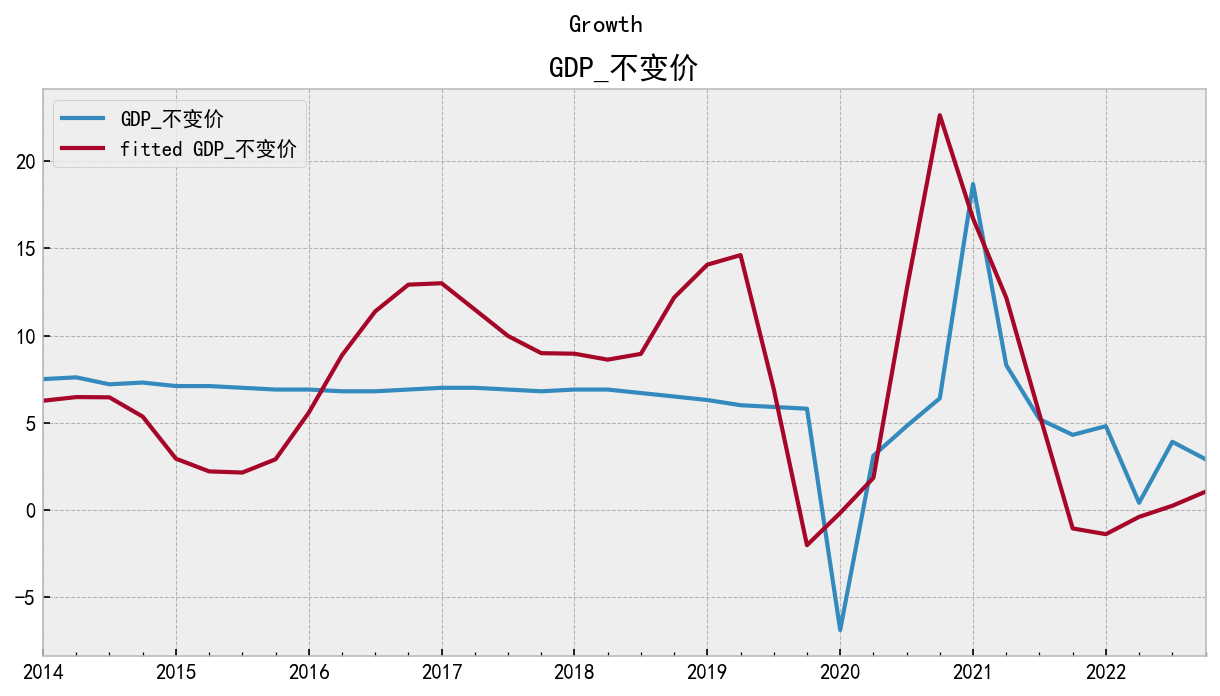

In [35]:
synthesis_plot(reg_data.copy(), target, res)
growth = synthesis_by_vol(ori_data.copy()[['工业增加值', '产量_发电量', 'PMI_生产', '销量_汽车', 'PMI_新订单']], 500)
# synthesis_plot(reg_data.copy(), target, corr_res)
# growth = synthesis_by_indicator_plot(reg_data.copy(), target[0], res, ['工业增加值','PMI_生产','固定资产投资完成额','工业企业_利润总额'])
# growth = synthesis_by_vol(ori_data.copy()[['工业增加值','PMI_生产','固定资产投资完成额','工业企业_利润总额']], 500)
# synthesis_by_indicator_plot(reg_data.copy(), target[0], select_by_regression(reg_data, target[0], res.loc[target[0]].index.tolist(), 5))

In [21]:
keyword = 'Inflation'
target = ['CPI', 'PPI_全部工业品']
main_freq = None
data_dict = {sheet:pd.read_excel('MacroData.xlsx', sheet_name=sheet, skiprows=1, index_col=0).iloc[:-1] for sheet in sheet_name if keyword in sheet}
for key, _data in data_dict.items():
    _data.columns = [columns_rename(x) for x in _data.columns]
    _data = _data.loc[:'2023-04-01']
    # 默认target都是一个数据频率
    if target[0] in _data.columns:
        main_freq = key.split('_')[-1]
        _data.loc[:, '广义通胀'] = 0.7*_data.loc[:, 'CPI']+0.3*_data.loc[:, 'PPI_全部工业品']
    data_dict[key] = _data
if main_freq is None:
    raise ValueError
print(main_freq)
    

target.append('广义通胀')


ori_data, reg_data = [],[]
for key, data in data_dict.items():
    for each in data.columns:
        if each in target:
            ori_data.append(preprocess(data[each].shift(1).copy(), interpolate=False).resample(rule='B').mean().interpolate())
        else:
            ori_data.append(preprocess(data[each].copy(), interpolate=False, dif=True).resample(rule='B').mean().interpolate())
ori_data = pd.concat(ori_data, axis=1)
ori_data.columns = list(chain(*[each.columns for each in data_dict.values()]))

for key, data in data_dict.items():
    for each in data.columns:
        if each in target:
            reg_data.append(preprocess(data[each].shift(1).copy(), interpolate=False))
        else:
            reg_data.append(preprocess(data[each].copy(), interpolate=False, dif=True).resample(rule=main_freq).mean().interpolate())
reg_data = pd.concat(reg_data, axis=1)
reg_data.columns = list(chain(*[each.columns for each in data_dict.values()]))
reg_data.dropna(subset=target, inplace=True)

res =indicator_rsquared_res(reg_data.copy(), target)
corr_res = indicator_corr_res(reg_data.copy(), target)
display(pd.concat([res, corr_res], axis=1))

C:\Users\ygwang\AppData\Local\Temp\ipykernel_4496\2391016238.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data.loc[:, '广义通胀'] = 0.7*_data.loc[:, 'CPI']+0.3*_data.loc[:, 'PPI_全部工业品']


M


beta         t  rsquared      corr
CPI       大宗价_猪肉                0.014437  5.380955  0.505029  0.715295
          价格指数_普钢_综合           -0.011771 -2.038949  0.172369 -0.331669
          价格指数_普钢_螺纹           -0.011178 -2.156529  0.164236 -0.350928
          价格指数_普钢_热卷           -0.009819 -1.836564  0.130620 -0.287076
          价格指数_铁矿石_进口矿         -0.003973 -0.844081  0.072145 -0.158803
          期货结算价(连续)_布伦特原油      -0.002564 -0.649611  0.038300 -0.114414
          秦皇岛港_平仓价_动力煤(Q5500K) -0.007083 -1.294229  0.031918 -0.192638
PPI_全部工业品 期货结算价(连续)_布伦特原油       0.085388  6.802047  0.749905  0.867760
          价格指数_普钢_螺纹            0.125534  7.250654  0.683336  0.831004
          价格指数_普钢_综合            0.127512  6.464367  0.648036  0.810387
          价格指数_普钢_热卷            0.106905  4.992755  0.546663  0.744362
          秦皇岛港_平仓价_动力煤(Q5500K)  0.139595  5.426983  0.539667  0.738625
          大宗价_猪肉               -0.050118 -3.274359  0.419563 -0.648644
          价格指数_铁矿石_进口矿          0.039947  1.687946  0.121534  0.352006
广义通胀      期货结算价(连续)_布伦特原油       0.025159  4.211507  0.528611  0.733219
          秦皇岛港_平仓价_动力煤(Q5500K)  0.038488  4.328617  0.372087  0.618695
          价格指数_普钢_螺纹            0.031044  3.686908  0.321883  0.581197
          价格指数_普钢_综合            0.028992  3.736075  0.294599  0.552099
          价格指数_普钢_热卷            0.023374  3.289371  0.238335  0.504354
          价格指数_铁矿石_进口矿          0.005842  0.756792  0.096387  0.160653
          大宗价_猪肉               -0.004846 -0.805887  0.046692 -0.208905

48
大宗价_猪肉 opposite direction...
广义通胀 ['期货结算价(连续)_布伦特原油', '秦皇岛港_平仓价_动力煤(Q5500K)', '价格指数_普钢_螺纹']


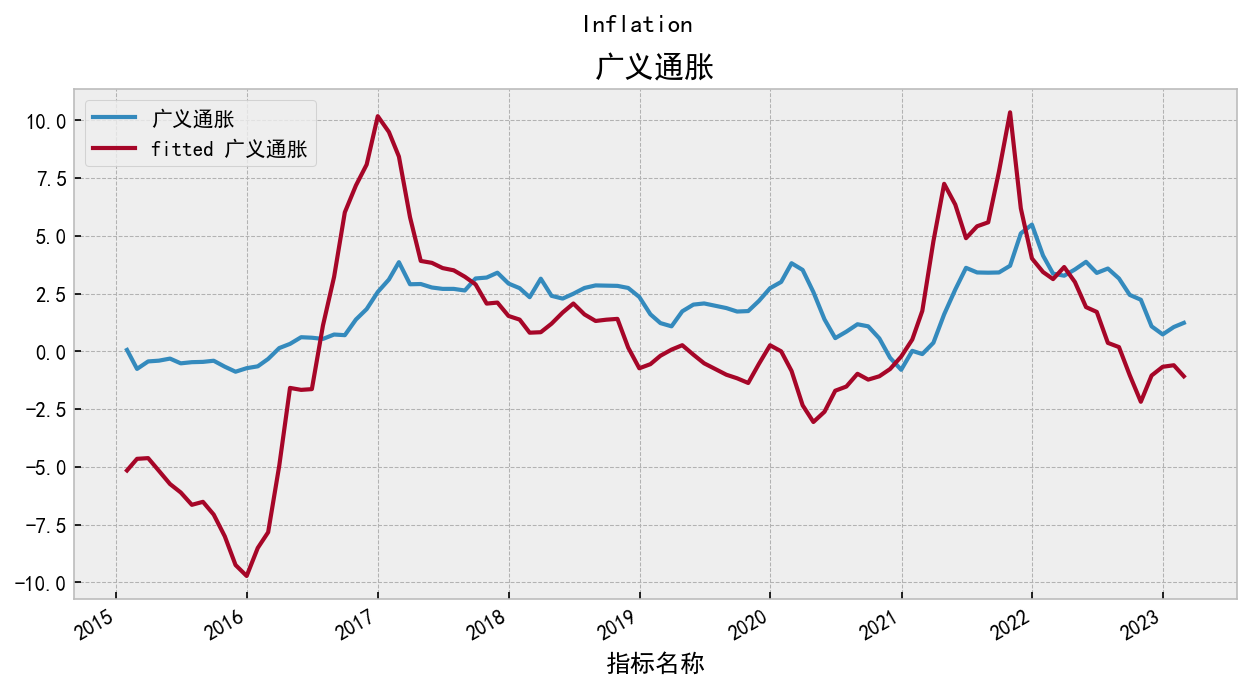

In [24]:
target = ['广义通胀']
# synthesis_plot(reg_data.copy(), target, res)
inflation = synthesis_by_indicator_plot(reg_data.copy(), target[0], res, ['期货结算价(连续)_布伦特原油', '秦皇岛港_平仓价_动力煤(Q5500K)', '价格指数_普钢_螺纹'])
inflation = synthesis_by_vol(ori_data.copy()[['期货结算价(连续)_布伦特原油', '秦皇岛港_平仓价_动力煤(Q5500K)', '价格指数_普钢_螺纹']], 500)

# synthesis_by_indicator_plot(reg_data.copy(), target[0], select_by_regression(reg_data, target[0], res.loc[target[0]].index.tolist(), 3))
# synthesis_plot(reg_data.copy(), target, corr_res, num=3)
# synthesis_by_indicator_plot(reg_data.copy(), target[0], ['大宗价_猪肉','期货结算价(连续)_布伦特原油','价格指数_普钢_综合'])

In [25]:
keyword = 'Money'
target = ['M1','M2']
main_freq = None
data_dict = {sheet:pd.read_excel('MacroData.xlsx', sheet_name=sheet, skiprows=1, index_col=0).iloc[:-1] for sheet in sheet_name if keyword in sheet}
for key, _data in data_dict.items():
    _data.columns = [columns_rename(x) for x in _data.columns]
    _data = _data.loc[:'2023-04-01']
    # 默认target都是一个数据频率
    if target[0] in _data.columns:
        main_freq = key.split('_')[-1]
    data_dict[key] = _data
    if '社会融资规模存量' in _data.columns:
        del _data['社会融资规模存量']
if main_freq is None:
    raise ValueError
print(main_freq)
    

ori_data, reg_data = [],[]
for key, data in data_dict.items():
    for each in data.columns:
        if each in target:
            ori_data.append(preprocess(data[each].shift(1).copy(), interpolate=False).resample(rule='B').mean().interpolate())
        else:
            ori_data.append(preprocess(data[each].copy(), interpolate=False, dif=True).resample(rule='B').mean().interpolate())
ori_data = pd.concat(ori_data, axis=1)
ori_data.columns = list(chain(*[each.columns for each in data_dict.values()]))

for key, data in data_dict.items():
    for each in data.columns:
        if each in target:
            reg_data.append(preprocess(data[each].shift(1), interpolate=False))
        else:
            reg_data.append(preprocess(data[each], interpolate=False, dif=True).resample(rule=main_freq).mean().interpolate())
reg_data = pd.concat(reg_data, axis=1)
reg_data.columns = list(chain(*[each.columns for each in data_dict.values()]))
reg_data.dropna(subset=target, inplace=True)

res =indicator_rsquared_res(reg_data.copy(), target)
corr_res = indicator_corr_res(reg_data.copy(), target)
display(pd.concat([res, corr_res], axis=1))

M


beta         t  rsquared      corr
M1 GC001_收盘价         0.005446  3.199579  0.175488  0.441329
   SHIBOR_3个月        0.032370  1.347023  0.033620  0.195857
   银行间质押式回购加权利率_7天   0.035045  1.082753  0.016681  0.172838
   回购定盘利率_7天(FR007)  0.027412  0.868347  0.011349  0.142869
   R-001_收盘价         0.000226  0.537958  0.002699  0.088689
   银行间同业拆借加权利率_7天    0.006659  0.194455 -0.002944  0.033310
   公开市场操作_货币净投放      0.000209  0.168077 -0.010077  0.026222
   R-007_收盘价         0.000135  0.470911 -0.010547  0.062806
M2 银行间同业拆借加权利率_7天   -0.043470 -2.984624  0.284320 -0.537380
   回购定盘利率_7天(FR007) -0.025304 -1.667454  0.122908 -0.366477
   银行间质押式回购加权利率_7天  -0.021745 -1.432884  0.094495 -0.317874
   SHIBOR_3个月       -0.010619 -0.929863  0.037148 -0.196371
   GC001_收盘价        -0.000025 -0.083978  0.006744 -0.007004
   公开市场操作_货币净投放      0.000221  1.387615 -0.006722  0.119361
   R-001_收盘价        -0.000054 -1.084127 -0.007604 -0.103435
   R-007_收盘价        -0.000065 -0.992571 -0.008349 -0.090888

48
银行间同业拆借加权利率_7天 opposite direction...
回购定盘利率_7天(FR007) opposite direction...
银行间质押式回购加权利率_7天 opposite direction...
SHIBOR_3个月 opposite direction...
GC001_收盘价 opposite direction...
R-001_收盘价 opposite direction...
R-007_收盘价 opposite direction...
M2 ['银行间同业拆借加权利率_7天', '回购定盘利率_7天(FR007)', '银行间质押式回购加权利率_7天']


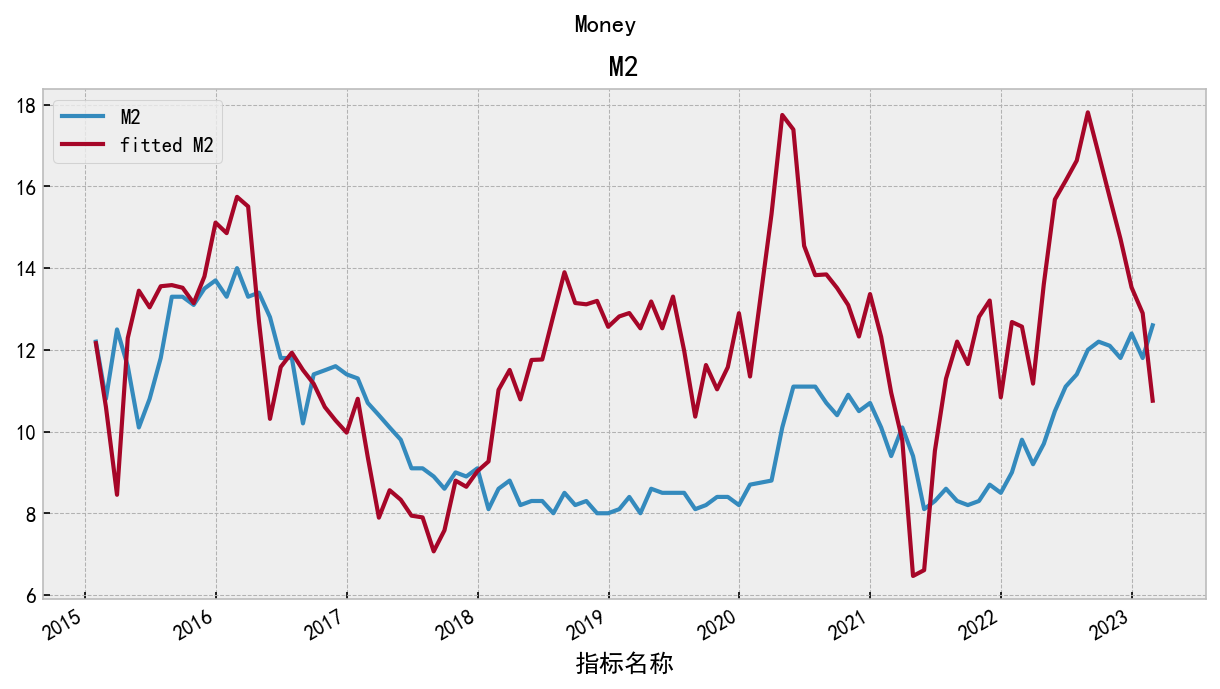

In [29]:
target=['M2']
money = synthesis_by_indicator_plot(reg_data.copy(), target[0], res, res.loc[target[0]].index.tolist()[:3])
money = synthesis_by_vol(ori_data.copy()[res.loc[target[0]].index.tolist()[:3]], 500)

In [10]:
keyword = 'Rate'
target = ['中证全指', '恒生指数', '中债-国债总财富(总值)指数']
main_freq = None
data_dict = {sheet:pd.read_excel('MacroData.xlsx', sheet_name=sheet, skiprows=1, index_col=0).iloc[:-1] for sheet in sheet_name if keyword in sheet}
df = pd.read_excel('MacroData.xlsx', sheet_name='Asset_D', skiprows=1, index_col=0)
df.columns = pd.read_excel('MacroData.xlsx', sheet_name='Asset_D', skiprows=0, index_col=0).columns
data_dict['Asset_D'] = df[target]
for key, _data in data_dict.items():
    _data.columns = [columns_rename(x) for x in _data.columns]
    _data = _data.loc[:'2023-04-01']
    # 默认target都是一个数据频率
    if target[0] in _data.columns:
        main_freq = key.split('_')[-1]
    data_dict[key] = _data
if main_freq is None:
    raise ValueError
print(main_freq)
    

reg_data = []
for key, data in data_dict.items():
    for each in data.columns:
        if each in target:
            reg_data.append(preprocess(data[each], interpolate=False, dif=True))
        else:
            reg_data.append(preprocess(data[each], interpolate=False, dif=True).resample(rule=main_freq).mean().interpolate())
reg_data = pd.concat(reg_data, axis=1)
reg_data.columns = list(chain(*[each.columns for each in data_dict.values()]))
reg_data.dropna(subset=target, inplace=True)

res =indicator_rsquared_res(reg_data.copy(), target)
corr_res = indicator_corr_res(reg_data.copy(), target)
display(pd.concat([res, corr_res], axis=1))

D


beta          t  rsquared      corr
中证全指           中债国债到期收益率_1年   0.137090   3.790178  0.154677  0.256660
               中债国债到期收益率_3个月  0.156552   4.757808  0.147267  0.336507
               中债国债到期收益率_2年   0.166698   4.179342  0.135493  0.260487
               中债国债到期收益率_20年  0.304483   4.560252  0.111223  0.277001
               中债国债到期收益率_3年   0.159408   3.627446  0.109552  0.213584
               中债国债到期收益率_1个月  0.124900   4.154860  0.106652  0.274856
               中债国债到期收益率_4年   0.163065   3.531927  0.100528  0.211280
               中债国债到期收益率_5年   0.175763   3.587937  0.090738  0.223789
               中债国债到期收益率_6年   0.185728   3.415610  0.085244  0.204242
               中债国债到期收益率_8年   0.188650   3.040681  0.080463  0.184211
               中债国债到期收益率_10年  0.181860   2.816623  0.080189  0.173839
               中债国债到期收益率_7年   0.189371   3.145631  0.079015  0.191108
恒生指数           中债国债到期收益率_10年  0.743918  15.519561  0.517143  0.719418
               中债国债到期收益率_5年   0.547085  12.762261  0.505408  0.711363
               中债国债到期收益率_8年   0.721360  14.713678  0.502536  0.709581
               中债国债到期收益率_7年   0.696438  14.362419  0.493611  0.702805
               中债国债到期收益率_6年   0.625052  13.470617  0.492387  0.701977
               中债国债到期收益率_4年   0.473914  12.066231  0.482931  0.695292
               中债国债到期收益率_3年   0.417820  11.521990  0.466202  0.683159
               中债国债到期收益率_2年   0.389424  11.379510  0.443441  0.666358
               中债国债到期收益率_1年   0.319057  10.548713  0.412977  0.643112
               中债国债到期收益率_20年  0.737997  12.147190  0.397850  0.631335
               中债国债到期收益率_3个月  0.276907  10.424037  0.340384  0.584042
               中债国债到期收益率_1个月  0.273322  10.129111  0.321551  0.567546
中债-国债总财富(总值)指数 中债国债到期收益率_8年  -0.210401 -69.312440  0.958447 -0.979023
               中债国债到期收益率_7年  -0.204014 -63.898341  0.956545 -0.978060
               中债国债到期收益率_10年 -0.213930 -69.532902  0.951606 -0.975520
               中债国债到期收益率_6年  -0.188234 -55.468655  0.945912 -0.972598
               中债国债到期收益率_20年 -0.242568 -47.551826  0.931478 -0.965150
               中债国债到期收益率_5年  -0.167160 -38.275774  0.919978 -0.959179
               中债国债到期收益率_4年  -0.154600 -31.721497  0.900150 -0.948800
               中债国债到期收益率_3年  -0.142318 -24.772195  0.866329 -0.930829
               中债国债到期收益率_2年  -0.127709 -23.535699  0.823725 -0.907727
               中债国债到期收益率_1年  -0.102204 -18.538820  0.751574 -0.867052
               中债国债到期收益率_3个月 -0.087075 -15.040096  0.629852 -0.793991
               中债国债到期收益率_1个月 -0.069596 -14.008213  0.507886 -0.712911

In [13]:
# print(select_by_regression(reg_data, target[0], res.loc[target[0]].index.tolist(), 5))
# print(select_by_regression(reg_data, target[1], res.loc[target[1]].index.tolist(), 5))
# print(select_by_regression(reg_data, target[2], res.loc[target[2]].index.tolist(), 5))

500
中债国债到期收益率_8年 opposite direction...
中债国债到期收益率_7年 opposite direction...
中债国债到期收益率_10年 opposite direction...
中债国债到期收益率_6年 opposite direction...
中债国债到期收益率_20年 opposite direction...
中债国债到期收益率_5年 opposite direction...
中债国债到期收益率_4年 opposite direction...
中债国债到期收益率_3年 opposite direction...
中债国债到期收益率_2年 opposite direction...
中债国债到期收益率_1年 opposite direction...
中债国债到期收益率_3个月 opposite direction...
中债国债到期收益率_1个月 opposite direction...
中债-国债总财富(总值)指数 ['中债国债到期收益率_1年', '中债国债到期收益率_8年', '中债国债到期收益率_20年']


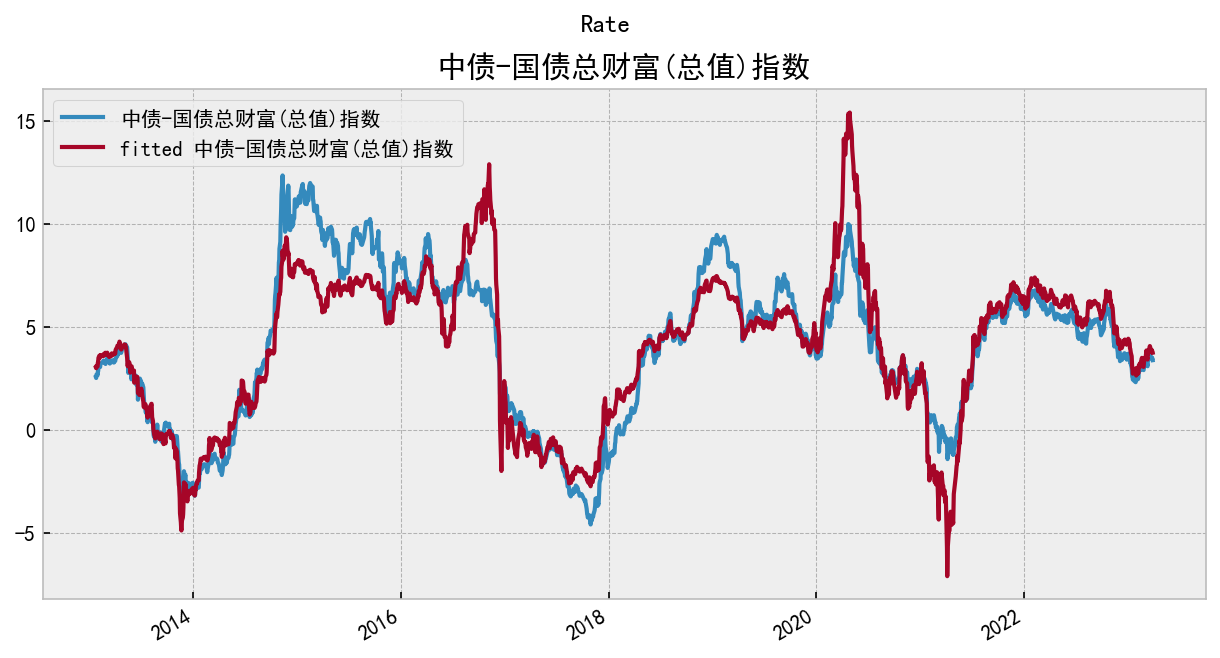

In [12]:
rate = synthesis_by_indicator_plot(reg_data.copy(), target[-1], res, ['中债国债到期收益率_1年','中债国债到期收益率_8年', '中债国债到期收益率_20年'])
# rate = synthesis_by_indicator_plot(reg_data.copy(), target[-1], res, [, '中债国债到期收益率_6年'])

In [13]:
keyword = 'Credit'
target = ['中债-国债总财富(总值)指数', '中债-企业债总财富(总值)指数', '中债-信用债总财富(总值)指数', '中债-中期票据总财富(总值)指数']
main_freq = None
data_dict = {sheet:pd.read_excel('MacroData.xlsx', sheet_name=sheet, skiprows=1, index_col=0).iloc[:-1] for sheet in sheet_name if keyword in sheet}
df = pd.read_excel('MacroData.xlsx', sheet_name='Asset_D', skiprows=1, index_col=0)
df.columns = pd.read_excel('MacroData.xlsx', sheet_name='Asset_D', skiprows=0, index_col=0).columns
data_dict['Asset_D'] = df[target]

for key, _data in data_dict.items():
    _data.columns = [columns_rename(x) for x in _data.columns]
    _data = _data.loc[:'2023-04-01']
    # 默认target都是一个数据频率
    if target[0] in _data.columns:
        main_freq = key.split('_')[-1]
    data_dict[key] = _data
if main_freq is None:
    raise ValueError
print(main_freq)

temp = pd.DataFrame(index=data_dict['Credit_D'].index)
for t in ['AAA', 'AA+', 'AA']:
    for y in [1, 3, 5]:
        temp[f'{t} 信用利差({y}Y)'] = data_dict['Credit_D'][f'中债中短期票据到期收益率({t})_{y}年'] - data_dict['Credit_D'][f'中债国债到期收益率_{y}年']
data_dict['Credit_D'] = temp

reg_data = []
for key, data in data_dict.items():
    for each in data.columns:
        if each in target:
            reg_data.append(preprocess(data[each], interpolate=False, dif=True))
        else:
            reg_data.append(preprocess(data[each], interpolate=False, dif=True).resample(rule=main_freq).mean().interpolate())
reg_data = pd.concat(reg_data, axis=1)
reg_data.columns = list(chain(*[each.columns for each in data_dict.values()]))
reg_data.dropna(subset=target, inplace=True)

res =indicator_rsquared_res(reg_data.copy(), target)
corr_res = indicator_corr_res(reg_data.copy(), target)
display(pd.concat([res, corr_res], axis=1))

D


beta          t  rsquared      corr
中债-国债总财富(总值)指数   AA+ 信用利差(5Y) -0.096107 -18.412422  0.509867 -0.714306
                 AAA 信用利差(5Y) -0.074844 -16.285911  0.499266 -0.706820
                 AA+ 信用利差(3Y) -0.071588 -15.860162  0.491956 -0.701813
                 AAA 信用利差(3Y) -0.055381 -13.410026  0.454262 -0.674162
                 AA+ 信用利差(1Y) -0.059594 -12.506701  0.411518 -0.641754
                 AA 信用利差(3Y)  -0.071087 -12.456968  0.406151 -0.637623
                 AAA 信用利差(1Y) -0.048536 -11.774251  0.390683 -0.625294
                 AA 信用利差(5Y)  -0.096134 -11.519446  0.357259 -0.598120
                 AA 信用利差(1Y)  -0.058984  -9.435404  0.327908 -0.573071
中债-企业债总财富(总值)指数  AA+ 信用利差(5Y) -0.089119 -24.973262  0.662964 -0.814348
                 AA+ 信用利差(3Y) -0.066057 -24.823139  0.658549 -0.811757
                 AAA 信用利差(3Y) -0.049735 -17.885967  0.626376 -0.791631
                 AAA 信用利差(5Y) -0.065556 -21.098851  0.614897 -0.784469
                 AA 信用利差(3Y)  -0.071561 -19.557161  0.573869 -0.757798
                 AA+ 信用利差(1Y) -0.056378 -17.399170  0.569983 -0.755234
                 AAA 信用利差(1Y) -0.046739 -16.309502  0.538876 -0.734400
                 AA 信用利差(5Y)  -0.090480 -16.353537  0.497350 -0.705471
                 AA 信用利差(1Y)  -0.055158 -14.315713  0.494307 -0.703376
中债-信用债总财富(总值)指数  AA+ 信用利差(3Y) -0.049187 -22.255973  0.591723 -0.769399
                 AAA 信用利差(5Y) -0.049769 -19.679153  0.577076 -0.759852
                 AAA 信用利差(3Y) -0.038117 -17.845244  0.574924 -0.758545
                 AA+ 信用利差(5Y) -0.064578 -20.824223  0.560719 -0.749121
                 AA+ 信用利差(1Y) -0.041655 -15.954925  0.504037 -0.710374
                 AAA 信用利差(1Y) -0.035413 -15.600724  0.491216 -0.701067
                 AA 信用利差(3Y)  -0.049876 -16.382778  0.460002 -0.678506
                 AA 信用利差(1Y)  -0.038996 -12.409329  0.410420 -0.641349
                 AA 信用利差(5Y)  -0.058052 -12.059175  0.353222 -0.594801
中债-中期票据总财富(总值)指数 AA+ 信用利差(3Y) -0.052438 -24.476773  0.646845 -0.804441
                 AAA 信用利差(3Y) -0.040979 -19.430755  0.628368 -0.792819
                 AAA 信用利差(5Y) -0.053267 -21.484830  0.613263 -0.783421
                 AA+ 信用利差(5Y) -0.067049 -22.262563  0.593925 -0.770879
                 AA+ 信用利差(1Y) -0.042854 -16.717162  0.561399 -0.749408
                 AAA 信用利差(1Y) -0.037497 -15.936975  0.545111 -0.738452
                 AA 信用利差(3Y)  -0.051494 -16.892881  0.477593 -0.691475
                 AA 信用利差(1Y)  -0.039519 -12.324603  0.434630 -0.659487
                 AA 信用利差(5Y)  -0.059930 -11.776332  0.355639 -0.597234

500
AA+ 信用利差(3Y) opposite direction...
AAA 信用利差(5Y) opposite direction...
AAA 信用利差(3Y) opposite direction...
AA+ 信用利差(5Y) opposite direction...
AA+ 信用利差(1Y) opposite direction...
AAA 信用利差(1Y) opposite direction...
AA 信用利差(3Y) opposite direction...
AA 信用利差(1Y) opposite direction...
AA 信用利差(5Y) opposite direction...
中债-信用债总财富(总值)指数 ['AA+ 信用利差(3Y)', 'AAA 信用利差(5Y)']


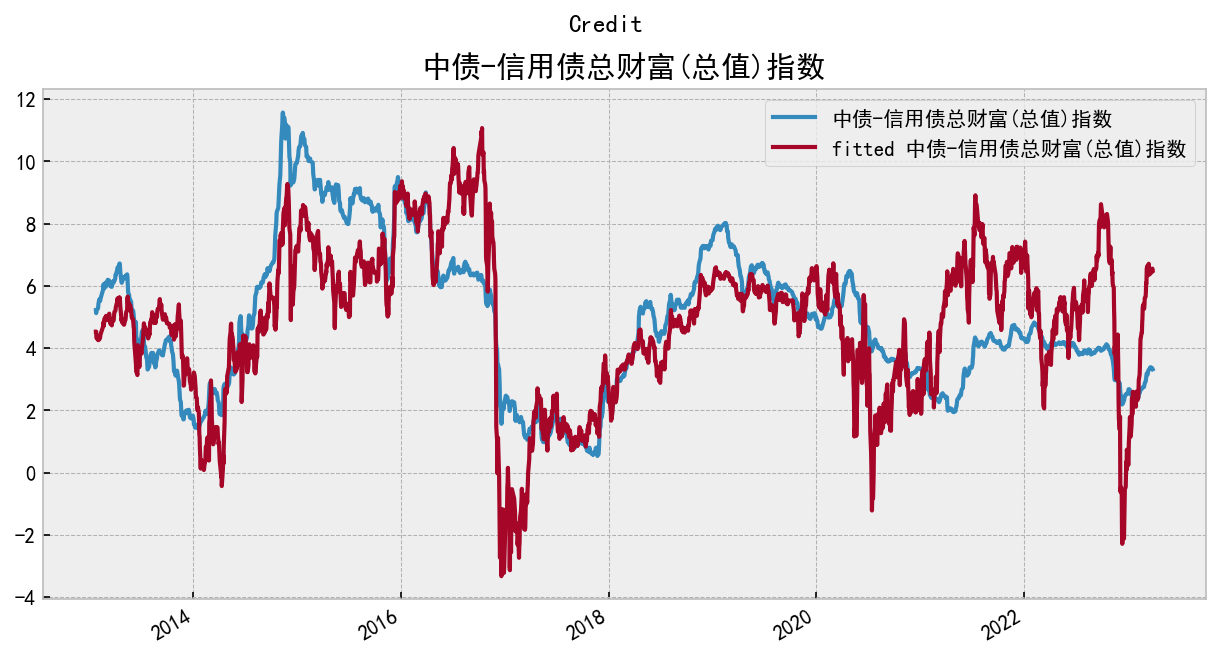

In [14]:
credit = synthesis_by_indicator_plot(reg_data.copy(), target[2], res, ['AA+ 信用利差(3Y)', 'AAA 信用利差(5Y)'])

In [15]:
keyword = 'Exchange'
target = ['CRB综合现货', 'LME铜', '南华商品指数', '伦敦金现', 'SGE黄金9999','中证全指','中债-国债总财富(总值)指数']
main_freq = None
data_dict = {sheet:pd.read_excel('MacroData.xlsx', sheet_name=sheet, skiprows=1, index_col=0).iloc[:-1] for sheet in sheet_name if keyword in sheet}
df = pd.read_excel('MacroData.xlsx', sheet_name='Asset_D', skiprows=1, index_col=0)
df.columns = pd.read_excel('MacroData.xlsx', sheet_name='Asset_D', skiprows=0, index_col=0).columns
data_dict['Asset_D'] = df[target]
for key, _data in data_dict.items():
    _data.columns = [columns_rename(x) for x in _data.columns]
    _data = _data.loc[:'2023-04-01']
    # 默认target都是一个数据频率
    if target[0] in _data.columns:
        main_freq = key.split('_')[-1]
    data_dict[key] = _data
if main_freq is None:
    raise ValueError
print(main_freq)
    

reg_data = []
for key, data in data_dict.items():
    for each in data.columns:
        if each in target:
            reg_data.append(preprocess(data[each], interpolate=False, dif=True))
        elif each in ['人民币实际有效汇率','人民币名义有效汇率']:
            reg_data.append(preprocess(data[each].shift(1), interpolate=False, dif=True).resample(rule=main_freq).mean().interpolate())
        else:
            reg_data.append(preprocess(data[each], interpolate=False, dif=True).resample(rule=main_freq).mean().interpolate())
reg_data = pd.concat(reg_data, axis=1)
reg_data.columns = list(chain(*[each.columns for each in data_dict.values()]))
reg_data.dropna(subset=target, inplace=True)

res =indicator_rsquared_res(reg_data.copy(), target)
corr_res = indicator_corr_res(reg_data.copy(), target)
display(pd.concat([res, corr_res], axis=1))

D


beta         t  rsquared      corr
CRB综合现货        人民币_名义有效汇率指数   0.099236  0.536527  0.482872  0.035050
               人民币_实际有效汇率指数  -0.526687 -4.001216  0.319570 -0.180289
               美元指数          -0.756879 -9.128162  0.319089 -0.575864
               中间价_港元兑人民币    -1.431680 -8.934787  0.297732 -0.532943
               中间价_美元兑人民币    -1.370544 -8.705817  0.285176 -0.516237
...                                ...       ...       ...       ...
中债-国债总财富(总值)指数 中间价_英镑兑人民币    -0.216553 -5.278164  0.103469 -0.320380
               中间价_100日元兑人民币  0.085097  4.683898  0.083682  0.267632
               人民币_名义有效汇率指数   0.128645  2.660129  0.072470  0.154727
               人民币_实际有效汇率指数   0.158929  2.797641  0.062175  0.165829
               中间价_加元兑人民币    -0.119720 -2.507407  0.032880 -0.157606

[63 rows x 4 columns]

500
人民币_名义有效汇率指数 opposite direction...
人民币_实际有效汇率指数 opposite direction...
中间价_港元兑人民币 opposite direction...
中间价_美元兑人民币 opposite direction...
中间价_英镑兑人民币 opposite direction...
美元指数 opposite direction...
南华商品指数 ['美元指数', '人民币_名义有效汇率指数']


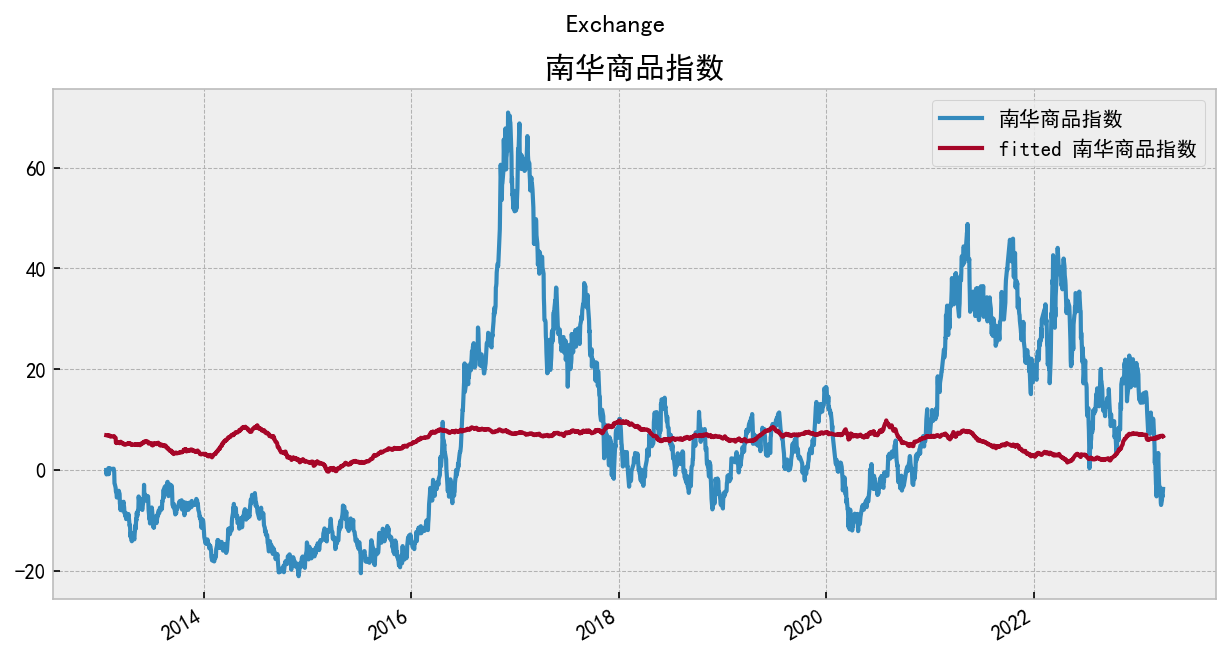

In [16]:
exchange = synthesis_by_indicator_plot(reg_data.copy(), '南华商品指数', res, ['美元指数','人民币_名义有效汇率指数'])
# synthesis_by_indicator_plot(reg_data.copy(), '中证全指', res, ['美元指数','人民币_名义有效汇率指数'])

In [17]:
final = pd.concat([growth, inflation, money, rate, credit, exchange], axis=1)
final.columns = MacroIndicator

In [20]:
final.dropna()

,Growth,Inflation,Rate,Money,Credit,Exchange
2013-01-23,16.687609,-1.859133,-1.430157,3.034843,4.530144,6.915380
2013-01-24,16.693947,-1.829550,-1.593666,2.994638,4.530403,6.903215
2013-01-25,16.700796,-1.868012,-1.747367,3.113784,4.330079,6.887386
2013-01-28,16.708155,-1.882627,-1.419137,3.094416,4.350375,6.866365
2013-01-29,16.716027,-1.800531,-0.310520,3.080026,4.278137,6.811280
...,...,...,...,...,...,...
2023-03-27,1.133241,-1.430608,1.671797,3.897150,6.430559,6.804036
2023-03-28,1.132455,-1.311922,1.704314,3.849100,6.506674,6.795108
2023-03-29,1.131731,-1.255702,1.610625,3.787938,6.552936,6.676798
2023-03-30,1.131067,-1.272748,2.704011,3.811898,6.553476,6.802620


In [19]:
final.dropna().to_csv('daily_macro_factor6.csv')

<AxesSubplot:>

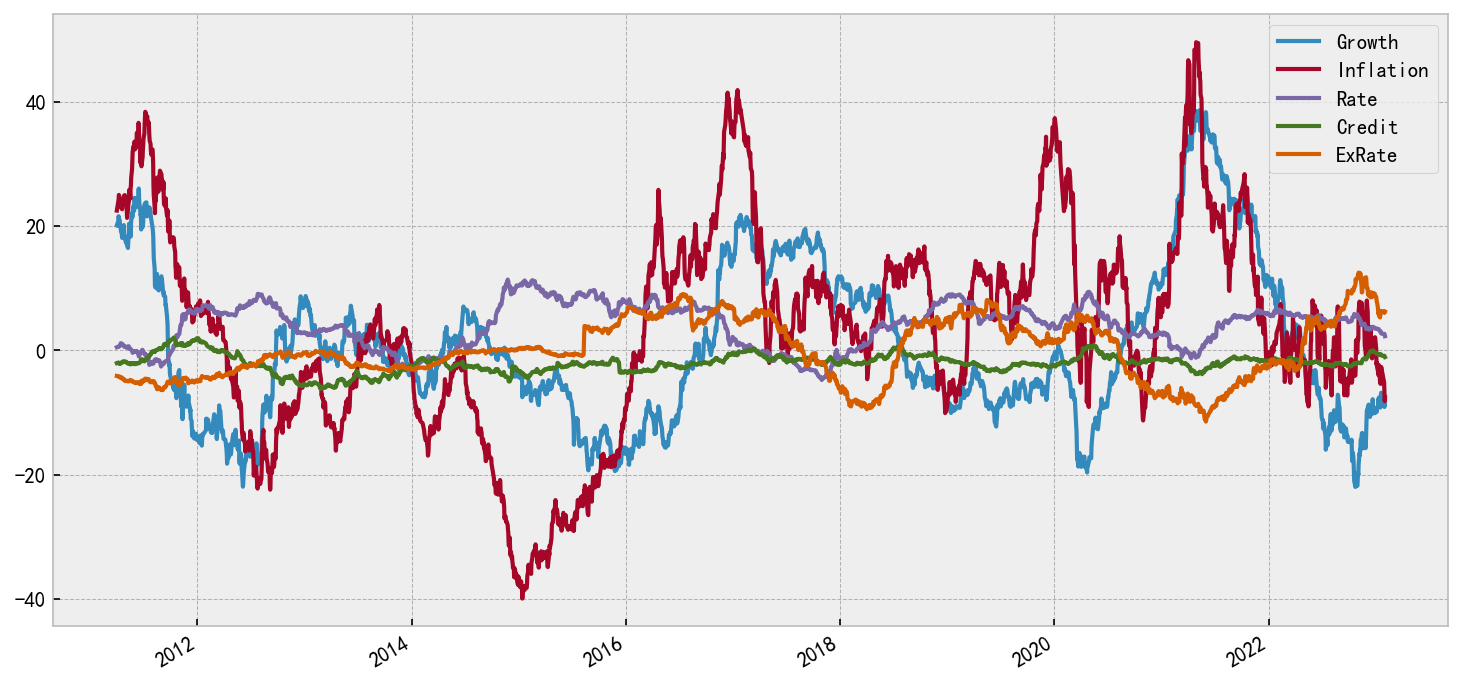

In [4]:
ori = pd.read_csv(r'D:\Project\dongfang\macro\input\macroFactorDf20230202_1.csv', parse_dates=True, index_col=0)
ori.plot(figsize=(12,6))

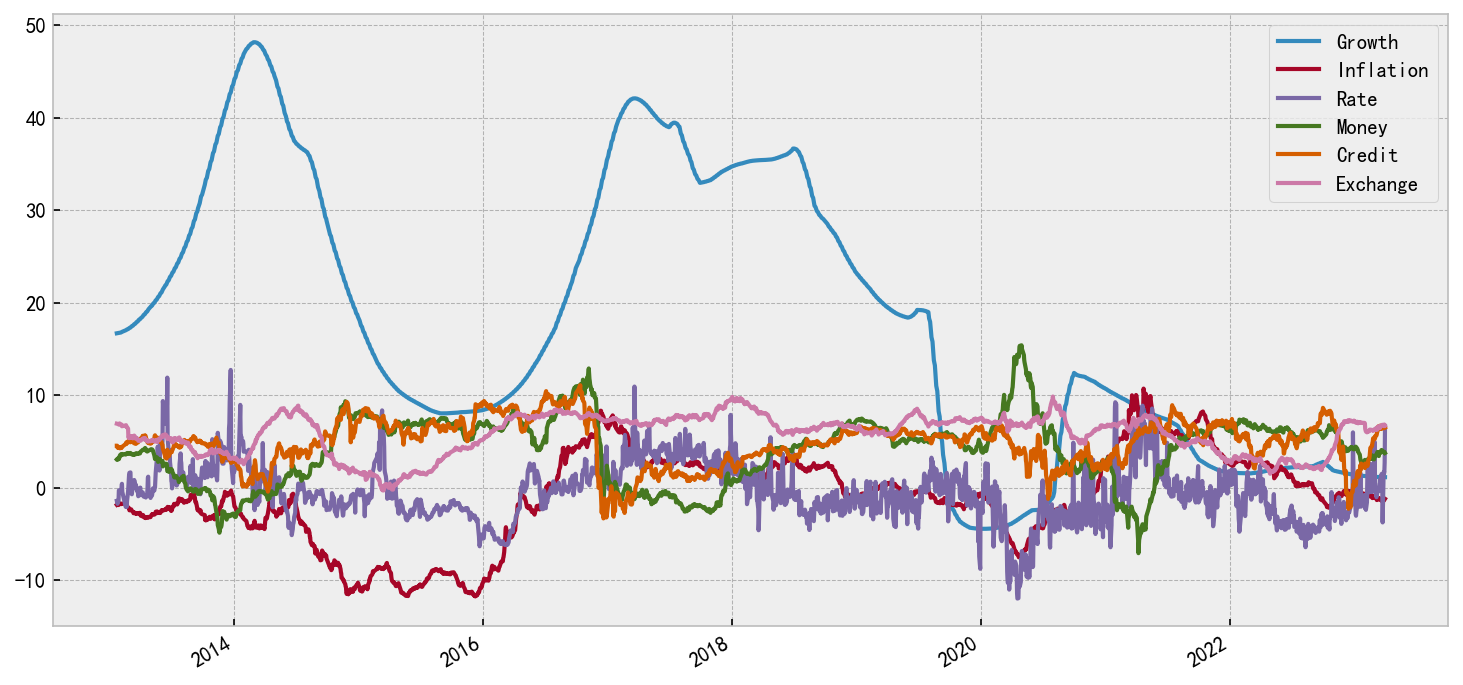

In [3]:
my = pd.read_csv(r'D:\Project\dongfang\macro\input\daily_macro_factor6.csv', parse_dates=True, index_col=0)
my.plot(figsize=(12,6))
my['ExRate'] = my['Exchange']

In [5]:
for x in ori.columns:
    print(x, ori.loc[ori.index.intersection(my.index)][x].corr(my.loc[ori.index.intersection(my.index)][x]))

Growth 0.2638570767975774
Inflation 0.7965534666368373
Rate -0.544950251441509
Credit -0.4446800601383197
ExRate 0.05667091174219776


## 升频

In [71]:
# data = pd.read_excel('MacroData.xlsx', sheet_name='Growth', skiprows=1, index_col=0).iloc[:-1]
# data.columns = [columns_rename(x) for x in data.columns]
# reg_data = []
# for each in data.columns:
#     if each == 'GDP_不变价':
#         reg_data.append(preprocess(data[each], interpolate=True))
#     elif 'PMI' in each:
#         reg_data.append(preprocess(data[each], interpolate=True, dif=True, season=True))
#     else:
#         reg_data.append(preprocess(data[each], interpolate=True, season=True))
# reg_data = pd.concat(reg_data, axis=1)
# reg_data.columns = data.columns

# reg_data[reg_data.columns[-1]] = reg_data[reg_data.columns[-1]].shift(-1)
# growth_res = Parallel(n_jobs=len(reg_data.columns[:-1]))(
#     delayed(bootstrap_regression)(
#         reg_data,
#         reg_data.columns[-1],
#         each_col
#     )
#     for each_col in reg_data.columns[:-1]
# )
# # growth_res = [bootstrap_regression(reg_data, reg_data.columns[-1], each_col) for each_col in reg_data.columns[:-1]]
# growth_res = pd.concat(growth_res, axis=1)
# # print(growth_res.T.sort_values('rsquared', ascending=False))
# a=growth_res.T.sort_values('rsquared', ascending=False).index.tolist()

In [72]:
# fig, ax = plt.subplots(1,1,figsize=(12,6))
# fitted = synthesis_by_vol(reg_data[a[:5]], 60)
# data['GDP_不变价'].loc[data.index.intersection(fitted.index)].replace(0.0,np.nan).dropna().plot(ax=ax)
# fitted.plot(ax=ax, label='fitted')
# plt.legend()
# plt.title('Growth')
# plt.show()
